In [1]:
#!/usr/bin/env python
# coding: utf-8

import os

default_n_threads = 1
os.environ['OPENBLAS_NUM_THREADS'] = f"{default_n_threads}"
os.environ['MKL_NUM_THREADS'] = f"{default_n_threads}"
os.environ['OMP_NUM_THREADS'] = f"{default_n_threads}"

import netCDF4 as nc
import sys
import time
import numpy as np
from numpy import ma as ma
from itertools import combinations



#Import packages for clustering
from sklearn.cluster import KMeans
from scipy.linalg import eigh

#Import packages for geodesic distences
from pyproj import Geod


#Import packages for interpolating and filtering data
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from scipy.interpolate import LinearNDInterpolator as LNDI
from scipy.interpolate import griddata

# Import package for parallel computing
from joblib import Parallel, delayed


year = 2009
season = "AMJ"
tmin = 8*4
print(f"Processing year {year}, season {season}")

IC_resolution = 0.5
dt = 0.0025
DT = 0.01
freq = 1
e = 0
#n_clusters = 20
# Format the variables
formatted_e = f"{e:.2f}"
formatted_DT = f"{DT:.4f}"
formatted_dt = f"{dt:.4f}"

# Construct file paths and directories
Fmap_params = f"{year}_{season}_"
Fmap_params += f"ic{IC_resolution}_"
Fmap_params += f"dt{formatted_dt}_"
Fmap_params += f"DT{formatted_DT}"
directory =  f"/cluster/projects/nn8008k/lluisa/NextSIM/seas/" #f"/nird/projects/NS11048K/lluisa/NextSIM/rotated_ice_velocities/seas/AMJ/"
file_path = f"{directory}Fmap_10days/{Fmap_params}/"
parent_directory = "/cluster/home/llpui9007/Programs/HPC_Spectral_Clustering"
results_directory = file_path
regrided_geo_file_path = f"{directory}OPA-neXtSIM_CREG025_ILBOXE140_{year}_ice_90Rx_{season}_regrided.nc"
geo_file_path = f"{directory}OPA-neXtSIM_CREG025_ILBOXE140_{year}_ice_90Rx_{season}.nc"
distance = 0 #0
k_exp = 100
d=10000 #e=0
d_reweighted=10000 #e=0
d_disp=10000 #e=0
time_steps_per_day=4


if not os.path.exists(results_directory):
    os.makedirs(results_directory)


# add utils folder to the TBarrier package
#sys.path.append(T_Barrier_directory+"/subfunctions/utils")
#sys.path.append(T_Barrier_directory+"/subfunctions/integration")
# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/Similarity_matrix_clustering")
sys.path.append(parent_directory+"/utils")
sys.path.append(parent_directory+"/subfunctions/Parallelisation")
sys.path.append(parent_directory+"/subfunctions/latlon_transform") 
sys.path.append(parent_directory+"/subfunctions/border_calculation")
from parallelised_functions import split3D

sys.path.append(parent_directory+"/subfunctions/trajectory_advection")
from Interpolant import generate_land_mask_interpolator , interpolant_unsteady_FTLE

from from_similarity_to_eigen import from_similarity_to_eigen, from_similarity_to_eigen_W, cut_trajectories_in_W , cut_trajectories_in_3W, from_similarity_to_eigen_W_spard #, from_similarity_to_eigesut_zones

from ploters import ini_final_clusters
from ploters import gif_clusters
from ploters import ini_final_clusters_landmask
from ploters import ini_final_clusters_landmask_ini
from ploters import gif_clusters_landmask
from degrees import degree_matrix
from polar_rotation import polar_rotation_rx 
from calculating_borders import borders_binary


Processing year 2009, season AMJ


In [2]:



# ### Clustering
def kmeans_w(n_clusters,l_vect):
    print("Applying k-means to define the clusters")

    kmeans = KMeans(init="random",n_clusters=n_clusters,n_init=1000,max_iter=10000)
    kmeans.fit(l_vect[:,0:n_clusters])
    labels = kmeans.labels_

    #plot_clusters_3w(Fmap, n_clusters, labels_reweighted, labels_disp, labels, "tab20")
    return labels



def kmeans_3w(n_clusters,l_vect_reweighted,l_vect_disp,l_vect,Fmap,d):
    print("Applying k-means to define the clusters")

    kmeans = KMeans(init="random",n_clusters=n_clusters,n_init=1000,max_iter=10000)
    kmeans.fit(l_vect[:,0:n_clusters])
    labels = kmeans.labels_
    kmeans.fit(l_vect_reweighted[:,0:n_clusters])
    labels_reweighted = kmeans.labels_
    kmeans.fit(l_vect_disp[:,0:n_clusters])
    labels_disp = kmeans.labels_


    Cluster_params = (
        f"nclusters{n_clusters}_"
        f"d{d:.2f}"
    )

    #plot_clusters_3w(Fmap, n_clusters, labels_reweighted, labels_disp, labels, "tab20")
    return labels_reweighted, labels_disp, labels



print("Reading data")
#Read input data
Fmap_path = file_path+'/'+str(int(tmin/time_steps_per_day))+'_Fmap_matrix_cleaned.npy'
time_path = file_path+'/'+str(int(tmin/time_steps_per_day))+'_advection_time.npy'
W_path_disp = file_path+'/'+str(int(tmin/time_steps_per_day))+'_W_disp_cleaned.npy'

# Load the Fmap array from the file
Fmap = np.load(Fmap_path)  # ntime [lon,lat] ntrajectories
#Fmap=Fmap[:,:,::100]
# Load the time_adv_mod array from the file
time_adv_mod = np.load(time_path)
# Load the similarity matrix
w_disp = np.load(W_path_disp)

dataset = nc.Dataset(regrided_geo_file_path, mode='r')
land_mask_reg = dataset.variables['land_mask'][:,:]
# Access coordinates
latitude_reg = dataset.variables['regrided_rot_lat'][:]  
longitude_reg = dataset.variables['regrided_rot_lon'][:]
dataset.close()


print("Cutting the trajectories that we don't want")
#W, Fmap_cut = cut_trajectories_in_W(Fmap, W_vec, distance,land_mask_reg,latitude_reg,longitude_reg)
#W_disp, Fmap_cut = cut_trajectories_in_W(Fmap, w_disp, distance,land_mask_reg,latitude_reg,longitude_reg)
#W_reweighted, Fmap_cut = cut_trajectories_in_W(Fmap, w_reweighted, distance,land_mask_reg,latitude_reg,longitude_reg)

W_disp, Fmap_cut = cut_trajectories_in_W(Fmap, w_disp, distance,land_mask_reg,latitude_reg,longitude_reg, eastSval=True, canadian_greenland=True)

K = 1000
np.fill_diagonal(W_disp,K)

formatted_distance = f"{distance:.2f}"

clusters_path = file_path+'/disp_clusters_K'+str(K)+'_border'+str(formatted_distance)+'_cleaned_center_spars/'
if not os.path.exists(clusters_path):
    os.makedirs(clusters_path)


spar = 10000
print("Sparsification distance: ")
print(str(spar))
if spar==10000:
    z=0
    formatted_spar = f"{z:.2f}"
else:
    formatted_spar = f"{spar:.2f}"

#l_vect,l,Fmap_cut_dist, W_cut_disp = from_similarity_to_eigen_W_spard(Fmap_cut,spar,W_disp,W_disp,K,k_exp)
if not os.path.exists(clusters_path):
    os.makedirs(clusters_path)




Reading data
Cutting the trajectories that we don't want
Number of points inside the polygons:
125384
Finally finished generating interpolator!
(1558,) trajectories have been removed because they were too close to land or ending up too close to land
Sparsification distance: 
10000


In [3]:
import itertools
# Example numerical vectors
positions_k = [1, 3, 5, 7]
positions_k_c = [2, 4, 6, 8]
# Generate all possible combinations
combinations = list(itertools.product(positions_k, positions_k_c))
# Swap elements to ensure i > j
ordered_combinations = [(min(i, j), max(i, j)) for i, j in combinations]

In [4]:
from itertools import combinations

def cut_weight_ratio(labels,W):
    within_sum = np.zeros(len(set(labels)))
    cluster_cut_weight = np.zeros(len(set(labels)))
    ic_within_sum = np.zeros(len(labels))
    ic_cut_weight = np.empty(len(labels))
    s_with = np.zeros(len(set(labels)))
    s_cut = np.zeros(len(set(labels)))
    W_tri = np.triu(W,k=1)
    #loop over each cluster
    for k in set(labels):
        positions_k = [index for index, value in enumerate(labels) if value == k]
        positions_k_c = [index for index, value in enumerate(labels) if value != k]
        pairs_k = combinations(positions_k, 2)  # itertools.combinations ensures i < j
        # Generate all possible combinations
        k_kc = list(itertools.product(positions_k, positions_k_c))
        # Swap elements to ensure i < j
        pairs_k_kc = [(min(i, j), max(i, j)) for i, j in k_kc]
        # Set matrix[i, j] to 0 for each pair
        
        for i, j in pairs_k:
            within_sum[k] = within_sum[k]+W_tri[i,j] 
            s_with[k]=s_with[k]+1

        if s_with[k]==0:
            within_sum[k]=0
        else:
            within_sum[k] = within_sum[k]/s_with[k]


        for i, j in pairs_k_kc:
            cluster_cut_weight[k] = cluster_cut_weight[k]+W_tri[i, j]
            s_cut[k]=s_cut[k]+1

        if s_cut[k]==0:
            cluster_cut_weight[k]=0
        else:
            cluster_cut_weight[k] = cluster_cut_weight[k]/s_cut[k]
        

    #loop over each initial condition
    for i in range(len(labels)): 
        ic_cut_weight[i] = cluster_cut_weight[labels[i]]
        ic_within_sum[i] = within_sum[labels[i]]

    return ic_cut_weight, ic_within_sum, s_with, s_cut

In [5]:
def cut_weight_individual(labels,W):
    within_sum = np.zeros(len(labels))
    cluster_cut_weight = np.zeros(len(labels))
    norm_within = np.empty(len(labels))
    norm_cut = np.empty(len(labels))
    #loop over each cluster
    for i in range(len(labels)):
        label=labels[i]
        s_within=0
        s_cut=0
        for k in set(labels):
            positions_k = [index for index, value in enumerate(labels) if value == k]
            if k==label:
                for j in positions_k:
                    if j!=i:
                        within_sum[i]=within_sum[i]+W[i,j]
                        s_within=s_within+1
            else:
                for j in positions_k:
                    assert j!=i, "Detecting the particle in another cluster! index problem"
                    cluster_cut_weight[i]=cluster_cut_weight[i]+W[i,j]
                    s_cut = s_cut+1
        
        if s_within==0:
            within_sum[k]=0
            print("Only one element in cluster "+str(label))
        else:
            within_sum[i]=within_sum[i]/s_within

        if s_cut==0:
            cluster_cut_weight[i]=0
            print("All the elements are in the same cluster")
        else:
            cluster_cut_weight[i]=cluster_cut_weight[i]/s_cut
            
        norm_within[i]=s_within
        norm_cut[i]=s_cut
        
    return cluster_cut_weight, within_sum, norm_within, norm_cut

In [6]:
def cut_weight_normalized(labels,W):

    D = np.sum(W,axis=0)-W_disp[0,0]
    cluster_vol = np.zeros(len(set(labels)))

    within_sum = np.empty(len(set(labels)))
    cluster_cut_weight = np.empty(len(set(labels)))
    ic_within_sum = np.zeros(len(labels))
    ic_cut_weight = np.empty(len(labels))
    W_tri = np.triu(W,k=1)

    #loop over each cluster
    for k in set(labels):
        positions_k = [index for index, value in enumerate(labels) if value == k]
        cluster_vol[k]=cluster_vol[k]+np.sum(D[positions_k])
        if cluster_vol[k]==0:
            print("The volume of cluster "+str(k)+" is zero!!")
            cluster_cut_weight[k]=0
            within_sum[k]=0
        else:
            positions_k = [index for index, value in enumerate(labels) if value == k]
            pairs_k = combinations(positions_k, 2)  # itertools.combinations ensures i < j
            for i, j in pairs_k:
                within_sum[k] = within_sum[k]+W_tri[i,j] 
            within_sum[k] = within_sum[k]/cluster_vol[k]
            
            positions_k_c = [index for index, value in enumerate(labels) if value != k]
            # Generate all possible combinations
            k_kc = list(itertools.product(positions_k, positions_k_c))
            # Swap elements to ensure i < j
            pairs_k_kc = [(min(i, j), max(i, j)) for i, j in k_kc]
            # Set matrix[i, j] to 0 for each pair
            for i, j in pairs_k_kc:
                cluster_cut_weight[k] = cluster_cut_weight[k]+W_tri[i, j]
            cluster_cut_weight[k]=cluster_cut_weight[k]/cluster_vol[k]

    #loop over each initial condition to assign the value of the cluster it belongs to for plotting pruposes
    for i in range(len(labels)): 
        ic_cut_weight[i] = cluster_cut_weight[labels[i]]
        ic_within_sum[i] = within_sum[labels[i]]
    
    return ic_cut_weight, ic_within_sum, cluster_vol


In [7]:
def cut_trajectories(distance,land_mask,latitude,longitude,canadian=True, eastSval=True, canadian_greenland=True):
    from scipy.ndimage import binary_dilation
    # Define the number of cells to expand the mask
    # Create a structuring element for dilation
    structuring_element = np.ones((2 * distance + 1, 2 * distance + 1))
    # Perform binary dilation to expand the mask
    thick_land_mask = binary_dilation(land_mask, structure=structuring_element)
    from shapely.geometry import Point, Polygon

        #tangent canadian archipelago leaving greenland tail
    polygon_vertices = [
        (-25,-110),
        (-5,-83),   # Vertex 2 (latitude, longitude)
        (-45, -50),    # Vertex 4 (latitude, longitude)
        (-45, -100)
    ]
    # Create a Polygon object using shapely
    polygon = Polygon(polygon_vertices)
    # Flatten the latitude and longitude matrices to create a list of points
    points = np.column_stack((latitude.ravel(), longitude.ravel()))
    # Use a list comprehension to check if each point is inside the polygon
    inside_mask = np.array([polygon.contains(Point(lat, lon)) for lat, lon in points])
    # Reshape the mask back to the original shape of the latitude matrix
    polygon_land_mask = inside_mask.reshape(latitude.shape)
    
    # Count the number of points inside the polygon
    inside_points_count = np.sum(polygon_land_mask)

    if canadian_greenland==True:
        # Define the vertices of the polygon
        #tangent canadian archipelago
        polygon_vertices = [
            (-20,-110),
            (10, -50),   # Vertex 2 (latitude, longitude)
            (-35, -50),    # Vertex 4 (latitude, longitude)
            (-40, -90)
        ]
        # Create a Polygon object using shapely
        polygon = Polygon(polygon_vertices)
        # Flatten the latitude and longitude matrices to create a list of points
        points = np.column_stack((latitude.ravel(), longitude.ravel()))
        # Use a list comprehension to check if each point is inside the polygon
        inside_mask = np.array([polygon.contains(Point(lat, lon)) for lat, lon in points])
        # Reshape the mask back to the original shape of the latitude matrix
        polygon_land_mask = polygon_land_mask + inside_mask.reshape(latitude.shape)
        # Count the number of points inside the polygon
        inside_points_count = np.sum(polygon_land_mask)
    if eastSval==True:
        #east of svalbard
        polygon_vertices = [
            (26,-70),
            (15, -98),   # Vertex 2 (latitude, longitude)
            (-20, -52),    # Vertex 4 (latitude, longitude)
            (-4, -54)
        ]
        # Create a Polygon object using shapely
        polygon = Polygon(polygon_vertices)
        # Flatten the latitude and longitude matrices to create a list of points
        points = np.column_stack((latitude.ravel(), longitude.ravel()))
        # Use a list comprehension to check if each point is inside the polygon
        inside_mask = np.array([polygon.contains(Point(lat, lon)) for lat, lon in points])
        # Reshape the mask back to the original shape of the latitude matrix
        polygon_land_mask = polygon_land_mask + inside_mask.reshape(latitude.shape)
        
        # Count the number of points inside the polygon
        inside_points_count = np.sum(polygon_land_mask)
    
    
    # Output the number of points inside the polygon
    print("Number of points inside the polygons:")
    print(str(inside_points_count))
    expanded_land_mask = thick_land_mask + polygon_land_mask
    return expanded_land_mask

In [8]:
#Import packages for plotting
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import matplotlib.animation as animation
from matplotlib.ticker import MaxNLocator
from pylab import imshow,cm
#Import packages for plotting
from matplotlib.colors import ListedColormap
import cartopy.crs as ccrs 
import cartopy.feature as cfeature  
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator

def plotpolar_weights(X_domain, Y_domain, cl, vmin, vmax,cmap,title): 
  
    Y_domain_rot, X_domain_rot = polar_rotation_rx(np.array(Y_domain),np.array(X_domain),-90) 

    # Create a figure with a polar stereographic projection centered on the North Pole 
    fig, ax = plt.subplots( 
        figsize=(8, 8), 
        subplot_kw={"projection": ccrs.NorthPolarStereo()}  # North Polar Stereographic projection 
    ) 
    # Choose a colormap (e.g., 'viridis')
    cmap = cmap #'viridis'
    cax = ax.scatter(np.asarray(X_domain_rot.ravel())[0,:], np.asarray(Y_domain_rot.ravel())[0,:], c= np.asarray(FTLE.ravel())[:], cmap= cmap,transform=ccrs.PlateCarree(), s=8,vmin=vmin,vmax=vmax)
    cbar = fig.colorbar(cax, ticks = np.linspace(0, .4, 9))
    cbar.set_label('[ ]', fontsize=18)
    cbar.ax.tick_params(labelsize=14)  # Adjust '14' to your desired tick size
    cbar.set_ticks([vmin, (vmin+vmax)/2, vmax])

    # Add coastlines and gridlines 
    ax.coastlines(resolution='50m', color='black', linewidth=0.8) 
    gl = ax.gridlines(draw_labels=False, color='gray', linestyle='--', linewidth=0.5) 
    gl.ylocator = plt.MultipleLocator(35)  # Latitude gridlines every 35 degrees
    # Set the extent to focus on the North Pole 
    ax.set_extent([-180, 180, 65, 90], crs=ccrs.PlateCarree()) 
    # Save and show the plot 
    plt.tight_layout() 
    plt.title(title)
    plt.show() 
    plt.close(fig)  # Close the figure to free up memory



def plot_clusters(Fmap, n_clusters, labels, cmap):
    """
    Plots clusters on a map using a polar rotation.
    Parameters:
        Fmap (numpy.ndarray): Input feature map.
        n_clusters (int): Number of clusters.
        labels (numpy.ndarray): Cluster labels for each point.
        cmap (str): Colormap name.
        img_name (str): File name to save the image.
    """
    # Define a colormap
    colors = plt.get_cmap(cmap, n_clusters)
    
    # Extract and rotate coordinates
    IC = Fmap[0, :, :]
    IC_lat, IC_lon = polar_rotation_rx(IC[1], IC[0], -90)  # Ensure polar_rotation_rx is defined
    positions_ini = np.asarray(np.vstack((IC_lon, IC_lat)))
    # Create the figure and axis
     # Create a figure with a polar stereographic projection centered on the North Pole 
    fig, ax = plt.subplots( 
        figsize=(8, 8), 
        subplot_kw={"projection": ccrs.NorthPolarStereo()}  # North Polar Stereographic projection 
    ) 
    
    # Scatter plot
    scatter = ax.scatter(
        positions_ini[0, :], positions_ini[1, :], 
        c=labels, cmap=colors, vmin=0, vmax=n_clusters - 1, 
        transform=ccrs.PlateCarree(), s=8
    )
    
    # Add coastlines
    ax.coastlines(resolution='50m', color='black', linewidth=0.8)
    
    # Add gridlines
    gl3 = ax.gridlines(draw_labels=False, color='gray', linestyle='--', linewidth=0.5)
    gl3.xlocator = MultipleLocator(45)
    gl3.ylocator = MultipleLocator(35)
    
    # Set map extent
    ax.set_extent([-180, 180, 65, 90], crs=ccrs.PlateCarree())
    
    # Adjust layout and add colorbar
    plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # Adjust layout to leave space for the colorbar
    cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', pad=0.02, fraction=0.05)
    cbar.set_label('Cluster Labels')
    
    # Show and close the figure
    plt.show()
    plt.close(fig)  # Close the figure to free up memory


def plotpolar_weights(X_domain, Y_domain, weights, vmin, vmax,cmap,title): 
  
    Y_domain_rot, X_domain_rot = polar_rotation_rx(np.array(Y_domain),np.array(X_domain),-90) 

    # Create a figure with a polar stereographic projection centered on the North Pole 
    fig, ax = plt.subplots( 
        figsize=(8, 8), 
        subplot_kw={"projection": ccrs.NorthPolarStereo()}  # North Polar Stereographic projection 
    ) 
    # Choose a colormap (e.g., 'viridis')
    cmap = cmap #'viridis'
    cax = ax.scatter(np.asarray(X_domain_rot.ravel())[0,:], np.asarray(Y_domain_rot.ravel())[0,:], c= np.asarray(weights.ravel())[:], cmap= cmap,transform=ccrs.PlateCarree(), s=8,vmin=vmin,vmax=vmax)
    cbar = fig.colorbar(cax, ticks = np.linspace(0, .4, 9))
    cbar.set_label('[ ]', fontsize=18)
    cbar.ax.tick_params(labelsize=14)  # Adjust '14' to your desired tick size
    cbar.set_ticks([vmin, (vmin+vmax)/2, vmax])

    # Add coastlines and gridlines 
    ax.coastlines(resolution='50m', color='black', linewidth=0.8) 
    gl = ax.gridlines(draw_labels=False, color='gray', linestyle='--', linewidth=0.5) 
    gl.ylocator = plt.MultipleLocator(35)  # Latitude gridlines every 35 degrees
    # Set the extent to focus on the North Pole 
    ax.set_extent([-180, 180, 65, 90], crs=ccrs.PlateCarree()) 
    # Save and show the plot 
    plt.tight_layout() 
    plt.title(title)
    plt.show() 
    plt.close(fig)  # Close the figure to free up memory


def plotpolar_weights_borders(X_domain, Y_domain, weights, borders_lat, borders_lon, vmin, vmax,cmap,title): 
  
    Y_domain_rot, X_domain_rot = polar_rotation_rx(np.array(Y_domain),np.array(X_domain),-90) 
    borders_lat_rot, borders_lon_rot = polar_rotation_rx(borders_lat,borders_lon,-90) 
    borders_lon_rot = np.asarray(borders_lon_rot)[0]
    borders_lat_rot = np.asarray(borders_lat_rot)[0]

    # Create a figure with a polar stereographic projection centered on the North Pole 
    fig, ax = plt.subplots( 
        figsize=(8, 8), 
        subplot_kw={"projection": ccrs.NorthPolarStereo()}  # North Polar Stereographic projection 
    ) 
    # Choose a colormap (e.g., 'viridis')
    cmap = cmap #'viridis'
    cax = ax.scatter(np.asarray(X_domain_rot.ravel())[0,:], np.asarray(Y_domain_rot.ravel())[0,:], c= np.asarray(weights.ravel())[:], cmap= cmap,transform=ccrs.PlateCarree(), s=3,vmin=vmin,vmax=vmax)
    cax2 = ax.scatter(borders_lon_rot, borders_lat_rot, c="Black",s=2,transform=ccrs.PlateCarree())
    cbar = fig.colorbar(cax, ticks = np.linspace(0, .4, 9))
    cbar.set_label('[ ]', fontsize=18)
    cbar.ax.tick_params(labelsize=14)  # Adjust '14' to your desired tick size
    cbar.set_ticks([vmin, (vmin+vmax)/2, vmax])

    # Add coastlines and gridlines 
    ax.coastlines(resolution='50m', color='black', linewidth=0.8) 
    gl = ax.gridlines(draw_labels=False, color='gray', linestyle='--', linewidth=0.5) 
    gl.ylocator = plt.MultipleLocator(35)  # Latitude gridlines every 35 degrees
    # Set the extent to focus on the North Pole 
    ax.set_extent([-180, 180, 65, 90], crs=ccrs.PlateCarree()) 
    # Save and show the plot 
    plt.tight_layout() 
    plt.title(title)
    plt.show() 
    plt.close(fig)  # Close the figure to free up memory

def plotpolar_weights_borders_fig(ax, X_domain, Y_domain, weights, borders_lat, borders_lon, vmin, vmax, cmap, title):
    Y_domain_rot, X_domain_rot = polar_rotation_rx(np.array(Y_domain), np.array(X_domain), -90)
    borders_lat_rot, borders_lon_rot = polar_rotation_rx(borders_lat, borders_lon, -90)
    borders_lon_rot = np.asarray(borders_lon_rot)[0]
    borders_lat_rot = np.asarray(borders_lat_rot)[0]
    # Choose a colormap
    cax = ax.scatter(
        np.asarray(X_domain_rot.ravel())[0, :],
        np.asarray(Y_domain_rot.ravel())[0, :],
        c=np.asarray(weights.ravel())[:],
        cmap=cmap,
        transform=ccrs.PlateCarree(),
        s=8,
        vmin=vmin,
        vmax=vmax
    )
    ax.scatter(borders_lon_rot, borders_lat_rot, c="Black", s=2, transform=ccrs.PlateCarree())
    ax.coastlines(resolution='50m', color='black', linewidth=0.8)
    gl = ax.gridlines(draw_labels=False, color='gray', linestyle='--', linewidth=0.5)
    gl.ylocator = plt.MultipleLocator(35)
    ax.set_extent([-180, 180, 65, 90], crs=ccrs.PlateCarree())
    ax.set_title(title)
    return cax

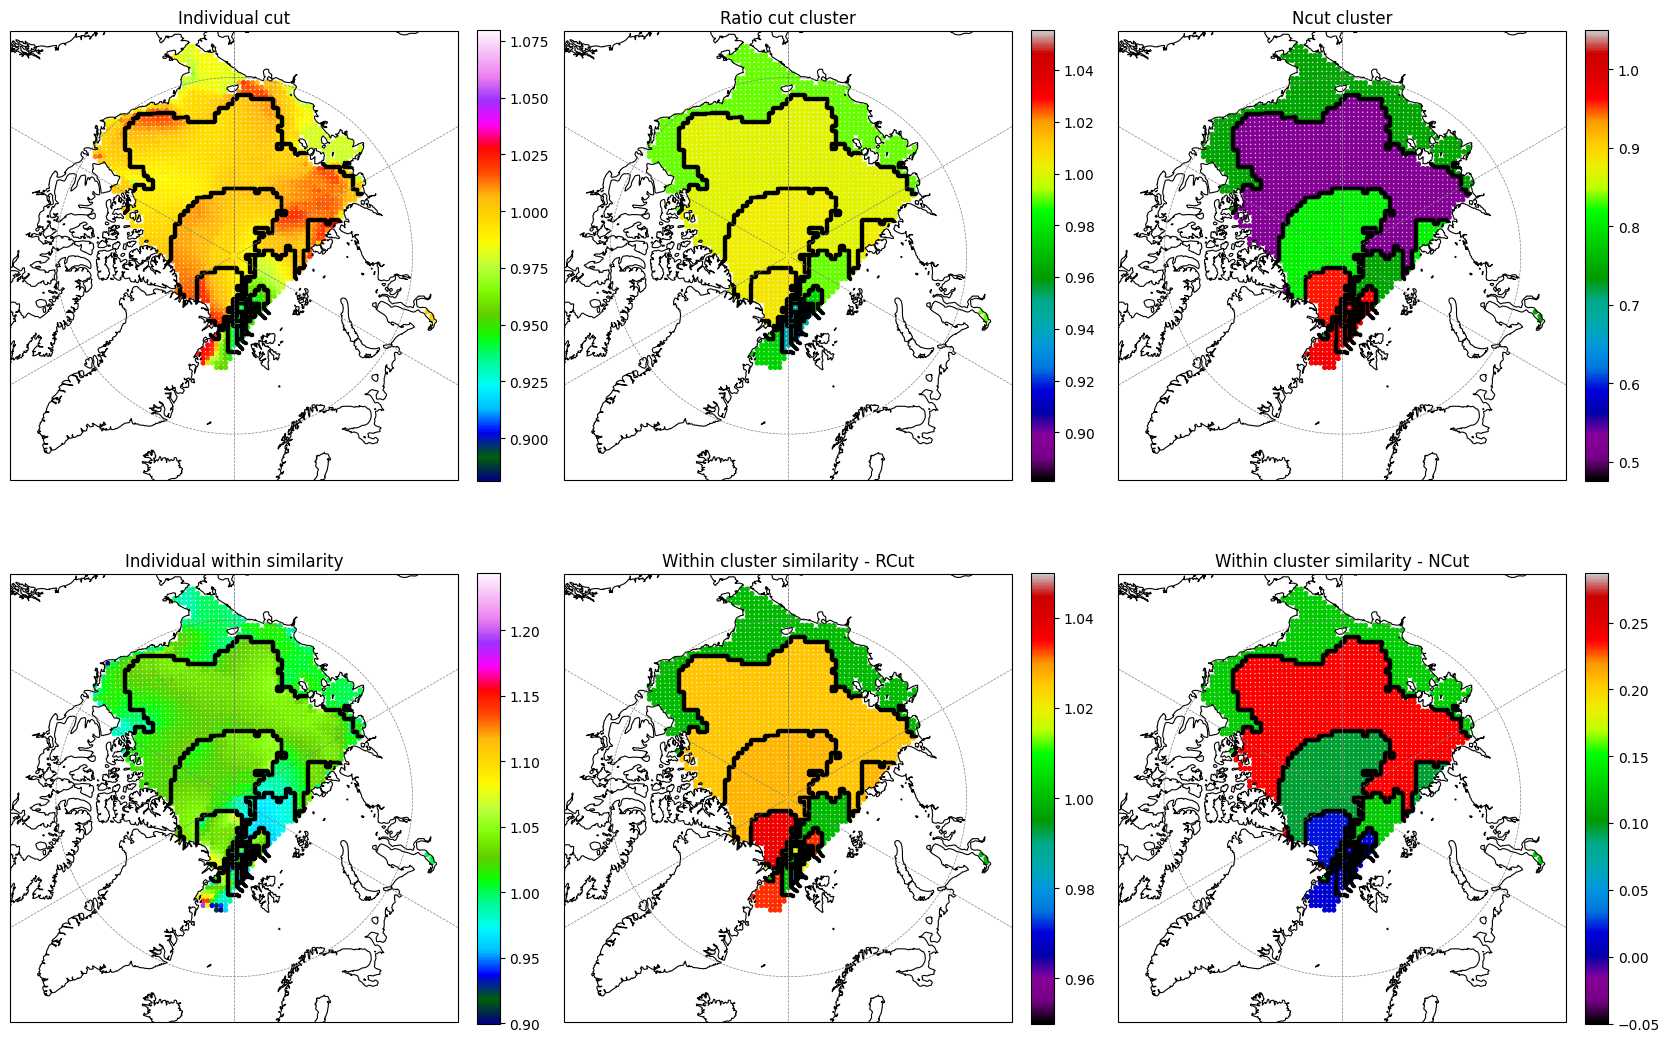

In [ ]:

print("Clustering")

#for n_clusters in (15,20, 25,30, 35):
n_clusters = 15

labels = np.load(clusters_path+str(n_clusters)+'_tmin'+str(int(tmin/time_steps_per_day))+'_spar'+str(formatted_spar)+'_labels.npy')

assert labels.shape[0] == W_disp.shape[0], f"Shapes do not match: {labels.shape[0]} != {W_disp.shape[0]}"

cut_weights_ratio, within_sum_ratio, s_within, s_cut = cut_weight_ratio(labels,W_disp)
cut_weights_norm, within_sum_norm, clusters_vol = cut_weight_normalized(labels,W_disp)
cut_weights_individual, within_sum_individual, norm_within, norm_cut = cut_weight_individual(labels,W_disp)


#np.save(clusters_path+str(n_clusters)+'_tmin'+str(int(tmin/time_steps_per_day))+'_spar'+str(formatted_spar)+'_labels.npy',labels)

ftle_path = "/cluster/projects/nn8008k/lluisa/NextSIM/seas/Fmap_10days/cleaned_FTLE_"+str(year)+"_"+season+"_dx0.100_dy0.100_dt0.100_grid_ratio0.010/"

print("Reading regrided input data")
"""
dataset = nc.Dataset(regrided_geo_file_path, mode='r')
# Access coordinates
X_domain = dataset.variables['regrided_rot_lat'][:]  
Y_domain = dataset.variables['regrided_rot_lon'][:]
dataset.close()
"""
domain_path = "/cluster/projects/nn8008k/lluisa/NextSIM/seas/Fmap_10days/"
X_domain = np.load(domain_path+"X_domain.npy")
Y_domain = np.load(domain_path+"Y_domain.npy")

FTLE_field = np.load(ftle_path + str(tmin) + "_FTLE.npy")
FTLE_field_plot = np.copy(FTLE_field)
mask = np.isnan(FTLE_field)
FTLE_field[np.isnan(FTLE_field)] = 0
Interpolant_FTLE = interpolant_unsteady_FTLE(X_domain, Y_domain, FTLE_field)


formatted_d=str(0)
spar=0
formatted_spar = f"{spar:.2f}"
FTLE = []

exp_mask = cut_trajectories(0,mask,Y_domain,X_domain,canadian=True, eastSval=True, canadian_greenland=True)

domain_path = "/cluster/projects/nn8008k/lluisa/NextSIM/seas/Fmap_10days/"
X_domain = np.load(domain_path+"X_domain.npy")
Y_domain = np.load(domain_path+"Y_domain.npy")

IC = Fmap_cut[0,:,:]  #Take the position of the trajectory IC
# Load the labels of the clusters
grid_labels = griddata((IC[0, :], IC[1, :]), labels, (X_domain,Y_domain), method='nearest')
borders_avg = borders_binary(grid_labels)
#plotpolar_ftle(X_domain, X_domain, borders_avg , -0.1, 0.1)
borders_avg = np.where(exp_mask,np.nan, borders_avg)
#plotpolar_ftle(X_domain, Y_domain, borders_avg , -0.1, 0.1)

borders_idx = np.where(borders_avg==1)
borders_lon_rot = X_domain[borders_idx]
borders_lat_rot = Y_domain[borders_idx]




# Create a figure with 2x2 subplots
fig, axes = plt.subplots(
    2, 3, figsize=(0.7*24, 0.7*16),
    subplot_kw={"projection": ccrs.NorthPolarStereo()}
)
# Plot each subplot
cax1 = plotpolar_weights_borders_fig(
    axes[0, 0], Fmap_cut[0, 0, :], Fmap_cut[0, 1, :], cut_weights_individual,
    borders_lat_rot, borders_lon_rot, cut_weights_individual.min()-0.05,
    cut_weights_individual.max()+0.05, 'gist_ncar', "Individual cut"
)
cax2 = plotpolar_weights_borders_fig(
    axes[1, 0], Fmap_cut[0, 0, :], Fmap_cut[0, 1, :], within_sum_individual,
    borders_lat_rot, borders_lon_rot, 0.9, within_sum_individual.max()+0.05,
    'gist_ncar', "Individual within similarity"
)
cax3 = plotpolar_weights_borders_fig(
    axes[0, 1], Fmap_cut[0, 0, :], Fmap_cut[0, 1, :], cut_weights_ratio,
    borders_lat_rot, borders_lon_rot, cut_weights_ratio.min()-0.05,
    cut_weights_ratio.max()+0.05, 'nipy_spectral', "Ratio cut cluster"
)
cax4 = plotpolar_weights_borders_fig(
    axes[1, 1], Fmap_cut[0, 0, :], Fmap_cut[0, 1, :], within_sum_ratio,
    borders_lat_rot, borders_lon_rot, 0.95, 1.05, 'nipy_spectral',
    "Within cluster similarity - RCut"
)
cax5 = plotpolar_weights_borders_fig(
    axes[0, 2], Fmap_cut[0, 0, :], Fmap_cut[0, 1, :], cut_weights_norm,
    borders_lat_rot, borders_lon_rot, cut_weights_norm.min()-0.05,
    cut_weights_norm.max()+0.05, 'nipy_spectral', "Ncut cluster"
)
cax6 = plotpolar_weights_borders_fig(
    axes[1, 2], Fmap_cut[0, 0, :], Fmap_cut[0, 1, :], within_sum_norm,
    borders_lat_rot, borders_lon_rot, within_sum_norm.min()-0.05, within_sum_norm.max()+0.05, 'nipy_spectral',
    "Within cluster similarity - NCut"
)
# Add colorbars for each subplot
fig.colorbar(cax1, ax=axes[0, 0], orientation='vertical', fraction=0.046, pad=0.04)
fig.colorbar(cax2, ax=axes[1, 0], orientation='vertical', fraction=0.046, pad=0.04)
fig.colorbar(cax3, ax=axes[0, 1], orientation='vertical', fraction=0.046, pad=0.04)
fig.colorbar(cax4, ax=axes[1, 1], orientation='vertical', fraction=0.046, pad=0.04)
fig.colorbar(cax5, ax=axes[0, 2], orientation='vertical', fraction=0.046, pad=0.04)
fig.colorbar(cax6, ax=axes[1, 2], orientation='vertical', fraction=0.046, pad=0.04)
# Adjust layout
plt.tight_layout()
plt.show()



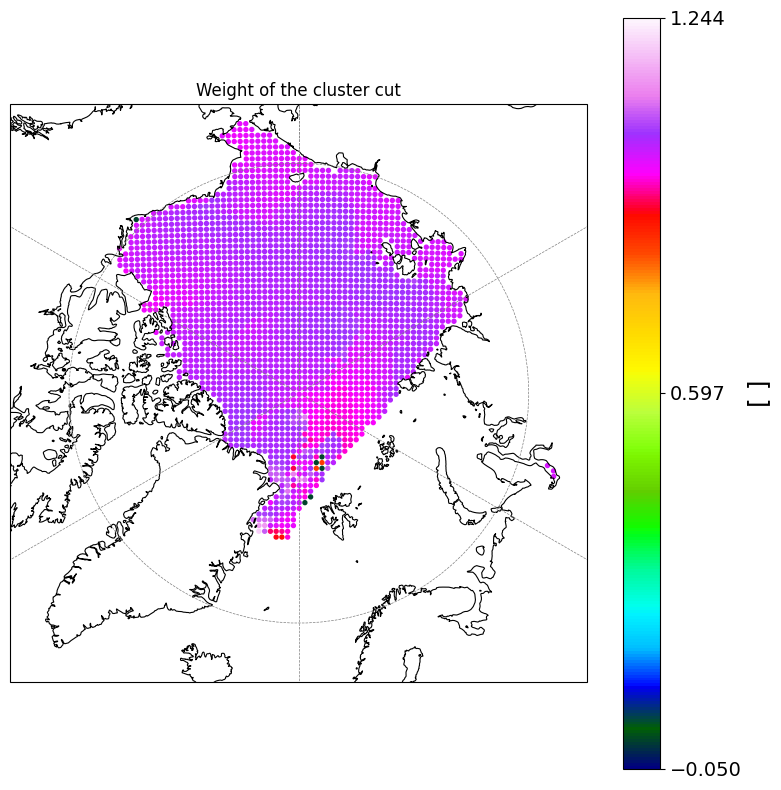

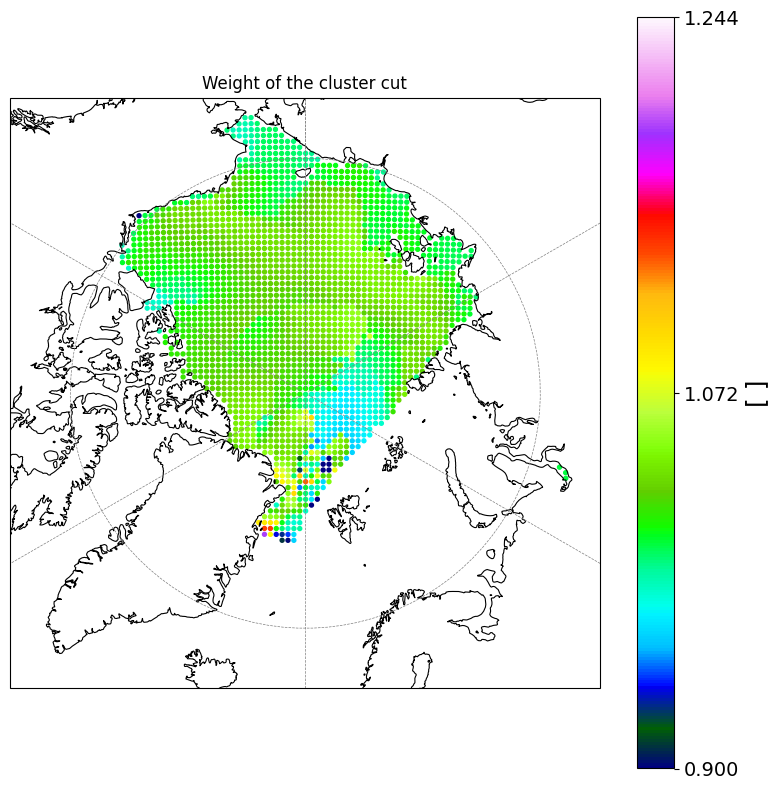

In [43]:
plotpolar_weights(Fmap_cut[0,0,:], Fmap_cut[0,1,:], within_sum_individual, within_sum_individual.min()-0.05, within_sum_individual.max()+0.05, 'gist_ncar', "Weight of the cluster cut")
plotpolar_weights(Fmap_cut[0,0,:], Fmap_cut[0,1,:], within_sum_individual, 0.9, within_sum_individual.max()+0.05, 'gist_ncar', "Weight of the cluster cut")
plotpolar_weights(Fmap_cut[0,0,:], Fmap_cut[0,1,:], cut_weights, cut_weights.min()-0.05, cut_weights.max()+0.05, 'nipy_spectral', "Weight of the cluster cut")
plotpolar_weights(Fmap_cut[0,0,:], Fmap_cut[0,1,:], within_sum, 0.95, 1.05, 'nipy_spectral',"Within similarity")# within_sum.min(), within_sum.max() , 'Reds') # )

In [66]:
np.mean(cut_weights_ratio)

np.float64(0.9969206062813676)

In [76]:
print("Clustering")

cut_ratio = []
within_ratio = []
cut_norm = []
within_norm = []

for n_clusters in range(2,30):
    print(str(n_clusters))
    labels = np.load(clusters_path+str(n_clusters)+'_tmin'+str(int(tmin/time_steps_per_day))+'_spar'+str(formatted_spar)+'_labels.npy')

    assert labels.shape[0] == W_disp.shape[0], f"Shapes do not match: {labels.shape[0]} != {W_disp.shape[0]}"

    cut_weights_ratio, within_sum_ratio, s_within, s_cut = cut_weight_ratio(labels,W_disp)
    cut_weights_norm, within_sum_norm, clusters_vol = cut_weight_normalized(labels,W_disp)
    #cut_weights_individual, within_sum_individual, norm_within, norm_cut = cut_weight_individual(labels,W_disp)
    cut_ratio.append(np.mean(cut_weights_ratio))
    within_ratio.append(np.mean(within_sum_ratio))
    cut_norm.append(np.mean(cut_weights_norm))
    within_norm.append(np.mean(within_sum_norm))


#np.save(clusters_path+str(n_clusters)+'_tmin'+str(int(tmin/time_steps_per_day))+'_spar'+str(formatted_spar)+'_labels.npy',labels)


Clustering
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


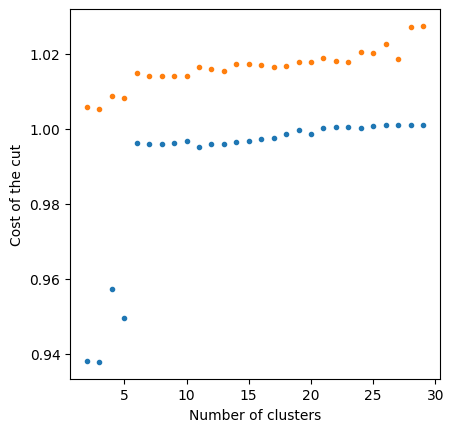

In [84]:
idx=[]
for i in range(2, 30):
    idx.append(i)
plt.plot(idx,cut_ratio,".")
plt.plot(idx,within_ratio,".")
plt.xlabel("Number of clusters")
plt.ylabel("Cost of the cut")
plt.gca().set_box_aspect(1) 

In [86]:
np.mean(within_sum_norm)

np.float64(0.059400371874622306)

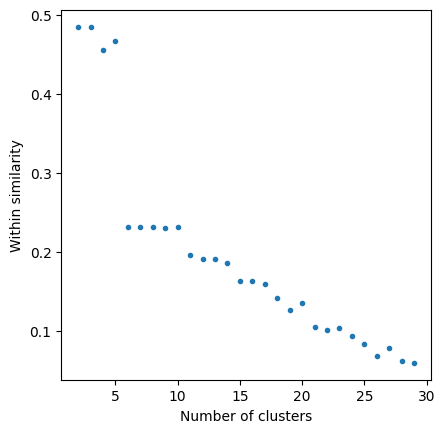

In [88]:
idx=[]
for i in range(2, 30):
    idx.append(i)
#plt.plot(idx,cut_norm,".")
plt.plot(idx,within_norm,".")
plt.xlabel("Number of clusters")
plt.ylabel("Within similarity")
plt.gca().set_box_aspect(1) 

ValueError: x and y must have same first dimension, but have shapes (28,) and (26,)

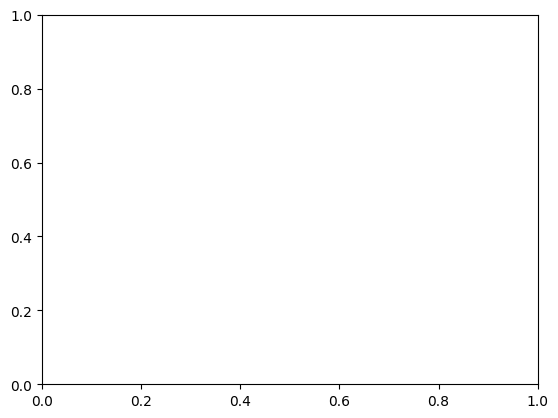

In [93]:
idx=[]
for i in range(2, 30):
    idx.append(i)
#idx=np.delete(idx,[21,26])
#cut_norm=np.delete(cut_norm,[21,26])
plt.plot(idx,cut_norm,".")
#plt.plot(idx,within_norm,".")
plt.xlabel("Number of clusters")
plt.ylabel("Within similarity")
plt.gca().set_box_aspect(1) 